<a href="https://colab.research.google.com/github/OguzSalihCIMRIN/Arduino/blob/master/notebooks/train-yolov12-object-detection-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [5]:
import os
from google.colab import userdata

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="48iCqQZ28XC2irBll6Q1")
project = rf.workspace("nesnetanima-tg7x3").project("yuztanima-kxfq1")
version = project.version(3)
dataset = version.download("yolov12")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to YuzTanima-3 in yolov12:: 100%|██████████| 1302/1302 [00:00<00:00, 10262.65it/s]


### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [6]:
!nvidia-smi

Sat Apr 19 05:11:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [8]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 83.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [ ]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-02-19 17:12:39--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-02-19 17:12:39 (95.4 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

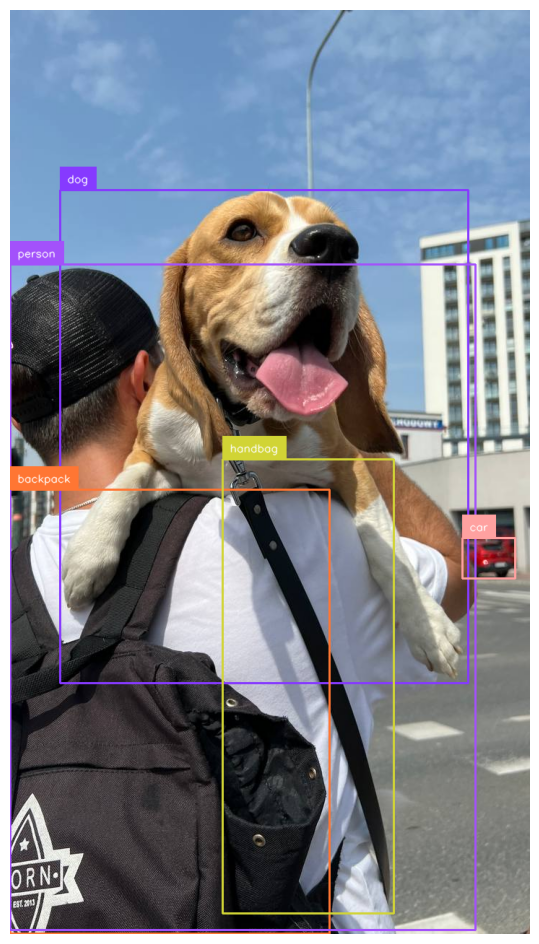

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [ ]:
from roboflow import download_dataset

dataset = download_dataset('https://universe.roboflow.com/roboflow-100/circuit-voltages/dataset/2', 'yolov8')

In [9]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [10]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [11]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 4
names: ['Kagan', 'Oguz', 'Pinar', 'Zeynep']

roboflow:
  workspace: nesnetanima-tg7x3
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [12]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.
New https://pypi.org/project/ultralytics/8.3.111 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/YuzTanima-3/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=

100%|██████████| 755k/755k [00:00<00:00, 32.7MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 148MB/s]


AMP: checks passed ✅


train: Scanning /content/YuzTanima-3/train/labels... 524 images, 14 backgrounds, 0 corrupt: 100%|██████████| 524/524 [00:00<00:00, 1411.57it/s]

train: New cache created: /content/YuzTanima-3/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/YuzTanima-3/valid/labels... 80 images, 0 backgrounds, 0 corrupt: 100%|██████████| 80/80 [00:00<00:00, 1117.80it/s]

val: New cache created: /content/YuzTanima-3/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.72G      2.999      3.912      4.176         35        640: 100%|██████████| 33/33 [00:17<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]

                   all         80         80    0.00343          1    0.00718    0.00297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.63G      2.883      3.723       3.97         31        640: 100%|██████████| 33/33 [00:16<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         80         80    0.00336          1     0.0314    0.00923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       6.8G      2.419      3.465      3.533         34        640: 100%|██████████| 33/33 [00:16<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]

                   all         80         80    0.00387          1     0.0366     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.82G      2.228      3.112      3.104         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80      0.765       0.25     0.0603       0.02



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.81G      2.042      2.823       2.78         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.509       0.25     0.0279     0.0118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.82G      1.866      2.561      2.524         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         80         80      0.828      0.242      0.208     0.0798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.82G      1.781      2.351      2.392         28        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]

                   all         80         80      0.438      0.711      0.519      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.82G      1.691      2.283      2.292         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         80         80      0.325      0.741      0.581      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       6.8G      1.557      2.104      2.189         25        640: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         80         80      0.292      0.651      0.546       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.82G      1.503      1.978      2.097         27        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         80         80      0.567      0.556      0.642      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.82G      1.448      1.885      2.066         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         80         80      0.305       0.82      0.582      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.82G      1.377      1.775      1.993         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.283      0.587      0.371      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.81G      1.311      1.657      1.922         27        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         80         80      0.337      0.758      0.597      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.82G        1.3      1.671      1.915         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.771      0.194     0.0434     0.0233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.82G      1.293      1.626       1.88         38        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.194      0.488      0.263      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.82G      1.238      1.556      1.849         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80       0.46      0.841      0.634      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.81G      1.223      1.551      1.835         25        640: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.576      0.815      0.839      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.82G      1.214      1.484      1.801         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.867      0.139      0.233      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.82G      1.212      1.448       1.81         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.704      0.827      0.885      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.82G      1.148       1.38      1.746         40        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         80         80      0.584      0.835      0.803      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100       6.8G      1.158      1.388      1.749         33        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         80         80      0.339      0.829      0.691      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.82G      1.108      1.339      1.698         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         80         80      0.834       0.78       0.87      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.82G      1.066      1.274      1.678         41        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

                   all         80         80      0.486      0.875      0.782      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.82G      1.035      1.343      1.664         33        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         80         80      0.736       0.88      0.887       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.81G      1.017      1.216      1.615         28        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.949      0.734      0.964      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.82G      0.988      1.164      1.592         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.831      0.915      0.941      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.82G          1      1.195      1.605         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.675       0.89      0.958       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.82G      1.033      1.193      1.628         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.817      0.895      0.958      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.81G      1.007      1.135      1.607         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         80         80      0.575      0.747        0.7      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.82G     0.9957      1.095      1.594         40        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         80         80      0.504      0.855      0.921      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.82G      1.022      1.125       1.61         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.489      0.707      0.542      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.82G     0.9914      1.094       1.58         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.735      0.894       0.96      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.81G     0.9987      1.101      1.579         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.813      0.866      0.929      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.82G     0.9577      1.086      1.556         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.399      0.544      0.413      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.82G     0.8989      1.001      1.512         33        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.809      0.885       0.95      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.82G     0.9317      1.023      1.538         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.759      0.854      0.925       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.81G      0.899      1.031      1.526         33        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.792      0.893      0.932      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.82G     0.9094     0.9962      1.527         38        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.883      0.888      0.963      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.82G     0.8616     0.9723      1.491         37        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80       0.62      0.836       0.76      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.82G     0.8469     0.9728       1.47         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80      0.528      0.789      0.691      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       6.8G     0.8773     0.9682      1.496         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.795      0.907      0.984      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.82G     0.8991     0.9398      1.506         37        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.913      0.947       0.99      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.82G     0.8844     0.9387      1.486         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.685      0.915      0.911      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.82G     0.8516     0.9491      1.479         39        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.824      0.786      0.924      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.81G     0.8364     0.9113       1.45         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         80         80      0.738      0.915      0.919      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.82G      0.857     0.8837      1.479         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.718      0.789      0.804      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.82G     0.8657     0.8749      1.467         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.832      0.951      0.985      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.82G     0.8305     0.8801      1.453         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         80         80      0.878      0.903      0.961      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.81G     0.8129     0.9065      1.447         33        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80       0.84      0.903       0.96      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.65G     0.8305     0.8803      1.433         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         80         80      0.898      0.885      0.964      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.82G     0.8488     0.9333      1.473         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80      0.788      0.865      0.922      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.82G     0.7806     0.8348      1.408         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         80         80      0.826      0.809      0.931      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       6.8G     0.8069     0.8661      1.453         37        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.762      0.897      0.902      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.65G     0.7789      0.825      1.413         29        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.913      0.949      0.991      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.82G     0.8118     0.8319      1.424         36        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80      0.938      0.898      0.993       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.82G     0.7599     0.8288      1.396         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80       0.97      0.979      0.994      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.81G     0.7654     0.7891      1.393         22        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         80         80      0.907      0.814      0.975      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.81G     0.7542     0.7728      1.382         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.939      0.954      0.983        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.82G     0.7906     0.8351      1.411         26        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80      0.858      0.914      0.979      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.82G     0.7664     0.7825      1.396         24        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         80         80       0.97      0.986      0.991      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.81G     0.7563      0.804      1.373         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         80         80      0.738      0.927      0.918      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.65G     0.8052     0.8154      1.414         37        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.921      0.944      0.988       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.82G     0.7428     0.7545       1.37         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.911      0.978      0.988      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.82G     0.7233      0.748      1.358         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.958      0.972      0.992      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.81G     0.7303      0.737      1.375         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         80         80      0.786      0.904      0.946      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.65G       0.73     0.7682      1.361         37        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80       0.98      0.953      0.993      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.82G     0.7024     0.7262       1.33         33        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.979      0.968      0.995      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.82G     0.7445     0.7365       1.36         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80       0.84      0.964      0.986      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.81G     0.6964     0.7126      1.329         35        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         80         80      0.926      0.952      0.986      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100       6.8G     0.6996     0.7384      1.343         24        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         80         80      0.915      0.963       0.99      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.82G     0.7233     0.7692      1.357         41        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         80         80      0.875      0.969      0.989      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.82G     0.7056     0.7054      1.331         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.959      0.971      0.993      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       6.8G      0.694     0.7441      1.333         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         80         80      0.943      0.979      0.993      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.65G     0.7036     0.7337      1.327         36        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.956      0.875      0.982      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.82G     0.7273     0.7556      1.358         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         80         80      0.946       0.96      0.992      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.82G     0.7118     0.7077       1.34         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.94it/s]

                   all         80         80      0.964      0.922      0.992      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.81G      0.666     0.7091      1.301         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         80         80       0.97      0.963      0.991      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.65G     0.6789     0.6623      1.314         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]


                   all         80         80      0.856      0.927      0.981        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.65G     0.6762     0.6977      1.318         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


                   all         80         80      0.887      0.884      0.968      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.65G     0.6767     0.6685       1.32         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         80         80      0.983      0.988      0.989      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.81G     0.6556     0.6632        1.3         32        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.907      0.908      0.974       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.81G     0.6548     0.6713      1.299         30        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.04it/s]

                   all         80         80      0.967      0.963      0.992      0.872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.82G     0.6636     0.6661      1.305         28        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.957      0.972      0.995      0.876



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.82G      0.652     0.6657      1.307         40        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.968      0.952      0.995      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.81G      0.625     0.6436      1.278         44        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.96it/s]

                   all         80         80      0.977      0.991      0.995       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.65G     0.6146     0.6584      1.282         34        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  3.00it/s]

                   all         80         80      0.959      0.986      0.995      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.82G     0.6452     0.6521        1.3         29        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80       0.97      0.981      0.993      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.82G     0.6401     0.6625      1.298         28        640: 100%|██████████| 33/33 [00:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.982      0.955      0.988      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.81G     0.5975      0.625      1.272         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.944      0.914      0.991      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.65G     0.6249     0.6593      1.286         31        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80       0.98      0.991      0.995      0.887


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.82G     0.6069     0.6301      1.445         12        640: 100%|██████████| 33/33 [00:17<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80      0.986      0.951      0.995      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.82G     0.5139     0.4908      1.324         11        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.955      0.935       0.99      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100       6.8G     0.4861     0.4792      1.311         12        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.987          1      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.81G     0.4962     0.4759      1.329         12        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.01it/s]

                   all         80         80      0.992      0.982      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.82G     0.4502     0.4349      1.262         12        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.979          1      0.995      0.896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.82G     0.4573     0.4391      1.295         12        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         80         80      0.985      0.977      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100       6.8G     0.4493     0.4192      1.287         12        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.984      0.991      0.995      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.65G     0.4539     0.4336      1.289         12        640: 100%|██████████| 33/33 [00:16<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.99it/s]

                   all         80         80      0.987          1      0.995      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.82G     0.4509     0.4294      1.259         11        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.02it/s]

                   all         80         80      0.985      0.995      0.995      0.908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.82G     0.4354     0.4105      1.255         11        640: 100%|██████████| 33/33 [00:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         80         80      0.993      0.995      0.995      0.913



100 epochs completed in 0.524 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 376 layers, 9,075,756 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]


                   all         80         80      0.992      0.995      0.995      0.913
                 Kagan          9          9      0.984          1      0.995      0.937
                  Oguz         25         25       0.99          1      0.995      0.945
                 Pinar         22         22      0.996          1      0.995      0.883
                Zeynep         24         24          1      0.979      0.995      0.887
Speed: 0.2ms preprocess, 9.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [13]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    train_batch1.jpg
confusion_matrix_normalized.png			    train_batch2970.jpg
confusion_matrix.png				    train_batch2971.jpg
events.out.tfevents.1745039743.08c0c83a7019.1058.0  train_batch2972.jpg
F1_curve.png					    train_batch2.jpg
labels_correlogram.jpg				    val_batch0_labels.jpg
labels.jpg					    val_batch0_pred.jpg
P_curve.png					    val_batch1_labels.jpg
PR_curve.png					    val_batch1_pred.jpg
R_curve.png					    val_batch2_labels.jpg
results.csv					    val_batch2_pred.jpg
results.png					    weights
train_batch0.jpg


In [24]:
!zip -r YuzTani.zip runs

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/P_curve.png (deflated 14%)
  adding: runs/detect/train/confusion_matrix_normalized.png (deflated 29%)
  adding: runs/detect/train/labels.jpg (deflated 46%)
  adding: runs/detect/train/confusion_matrix.png (deflated 33%)
  adding: runs/detect/train/args.yaml (deflated 53%)
  adding: runs/detect/train/results.png (deflated 6%)
  adding: runs/detect/train/R_curve.png (deflated 14%)
  adding: runs/detect/train/weights/ (stored 0%)
  adding: runs/detect/train/weights/last.pt (deflated 9%)
  adding: runs/detect/train/weights/best.pt (deflated 9%)
  adding: runs/detect/train/results.csv (deflated 61%)
  adding: runs/detect/train/train_batch2971.jpg (deflated 12%)
  adding: runs/detect/train/val_batch2_pred.jpg (deflated 15%)
  adding: runs/detect/train/train_batch2972.jpg (deflated 11%)
  adding: runs/detect/train/labels_correlogram.jpg (deflated 49%)
  adding: r

In [23]:
!ls


runs  sample_data  yolov12n.pt	YuzTanima-3


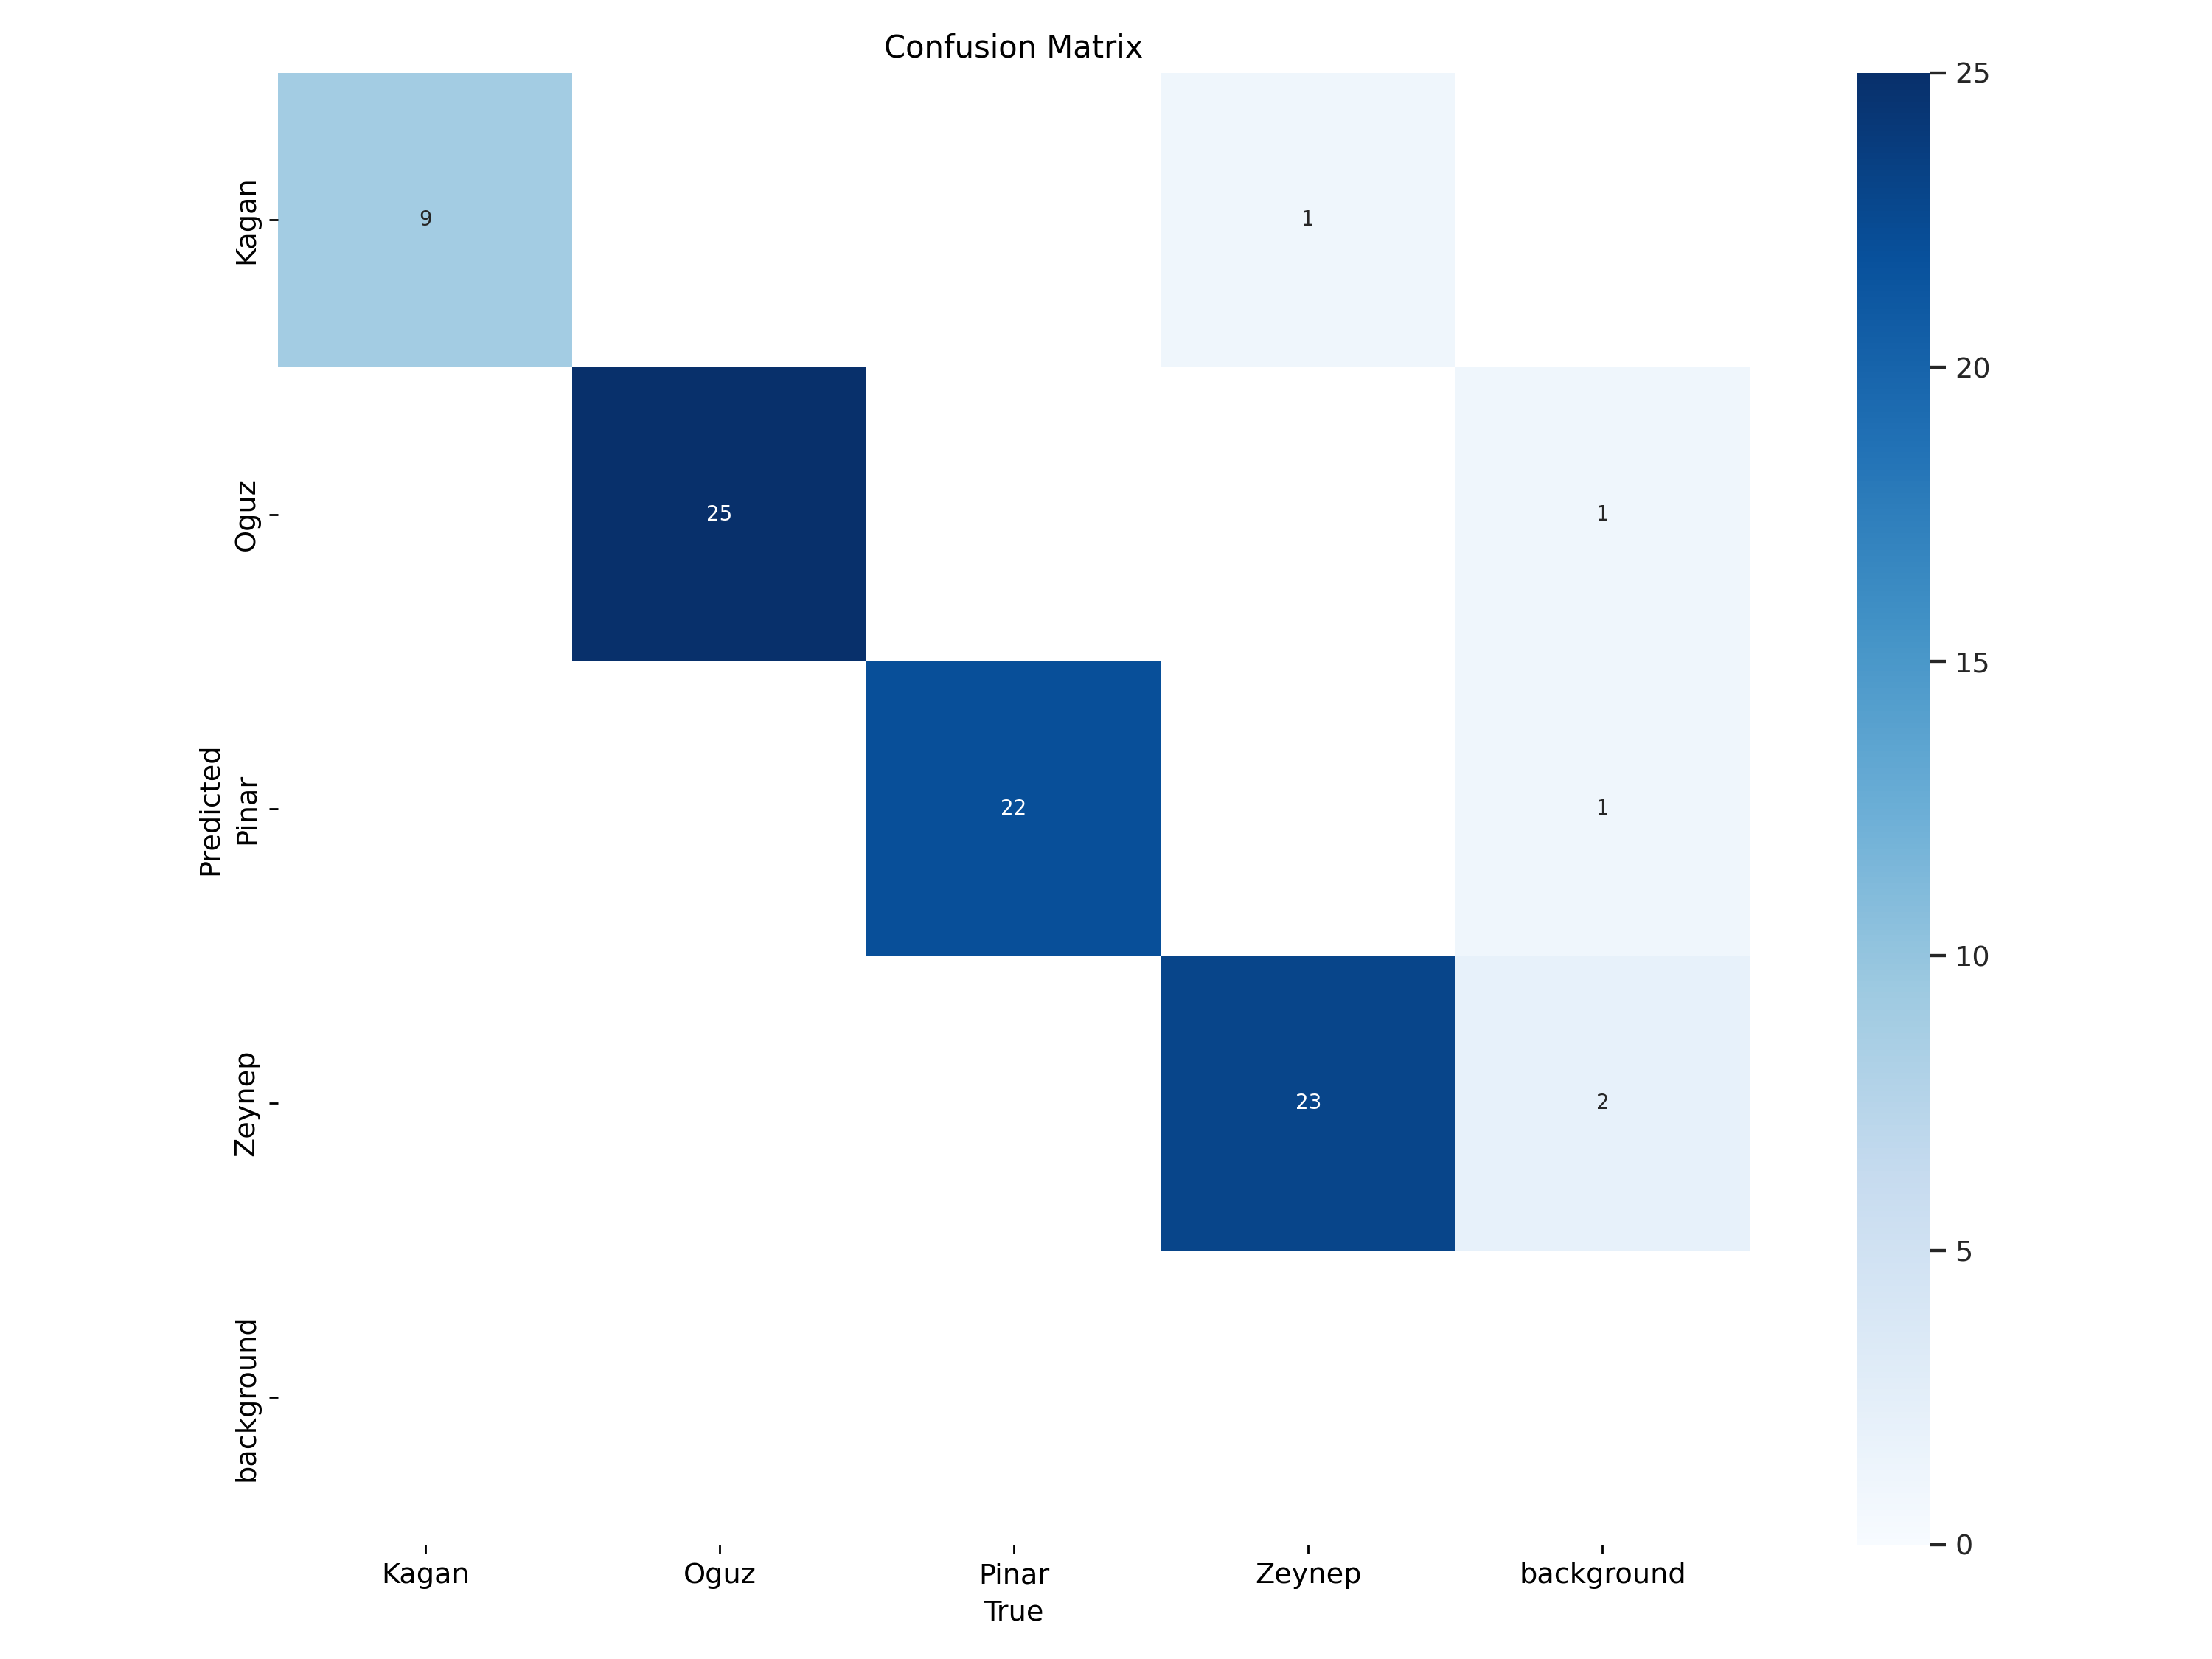

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

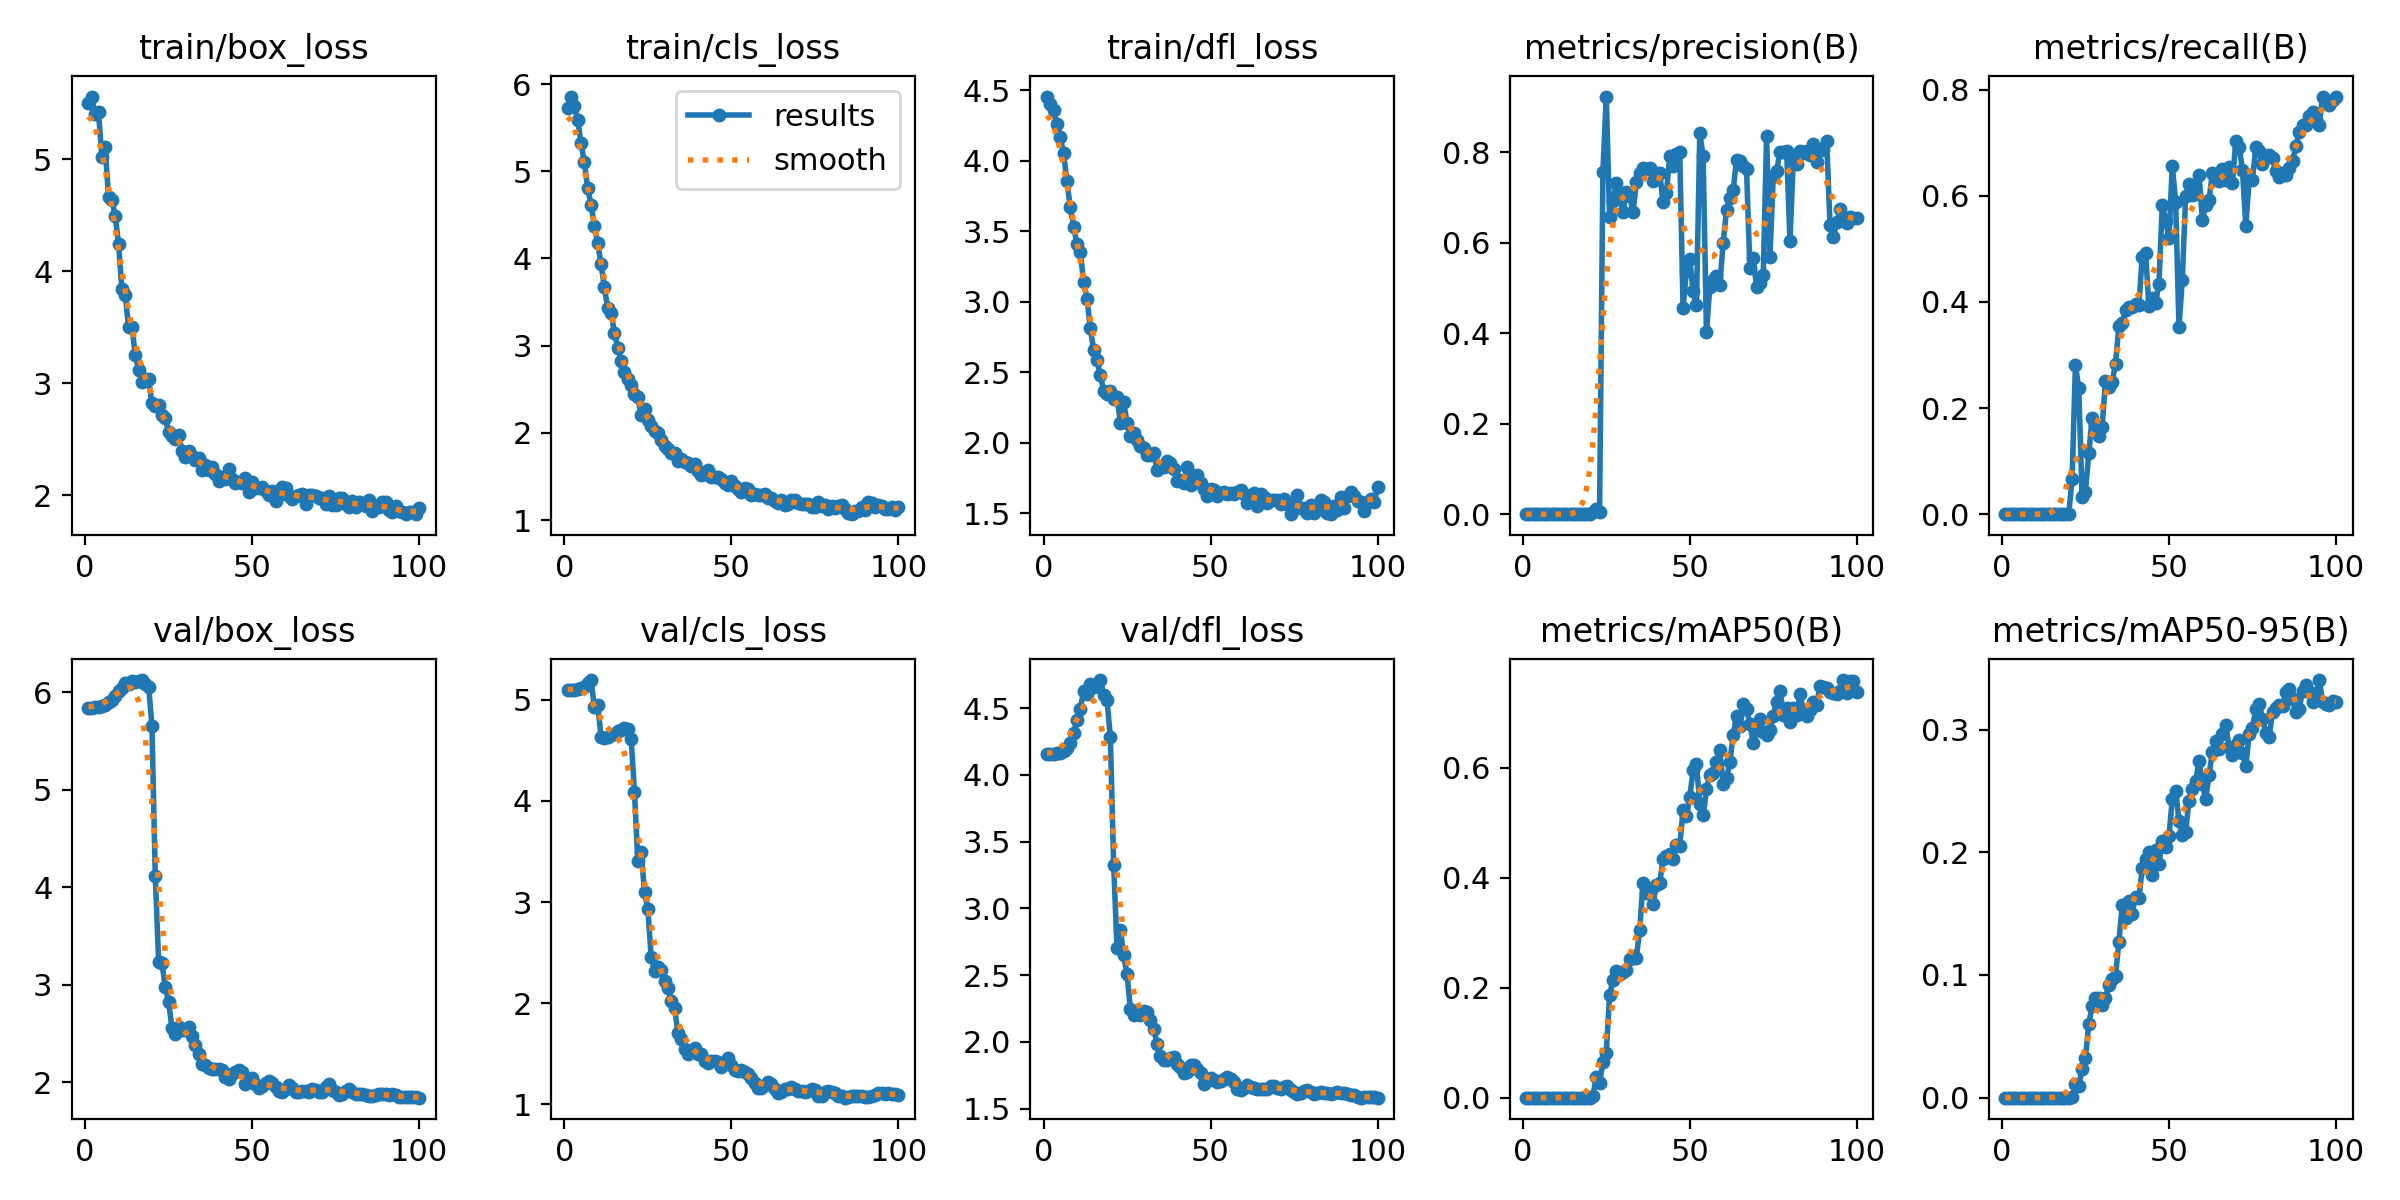

In [ ]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [15]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Kagan', 'Oguz', 'Pinar', 'Zeynep']

In [16]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [17]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.8810967999272453
mAP 50 0.9999999999999999
mAP 75 0.9999999999999999


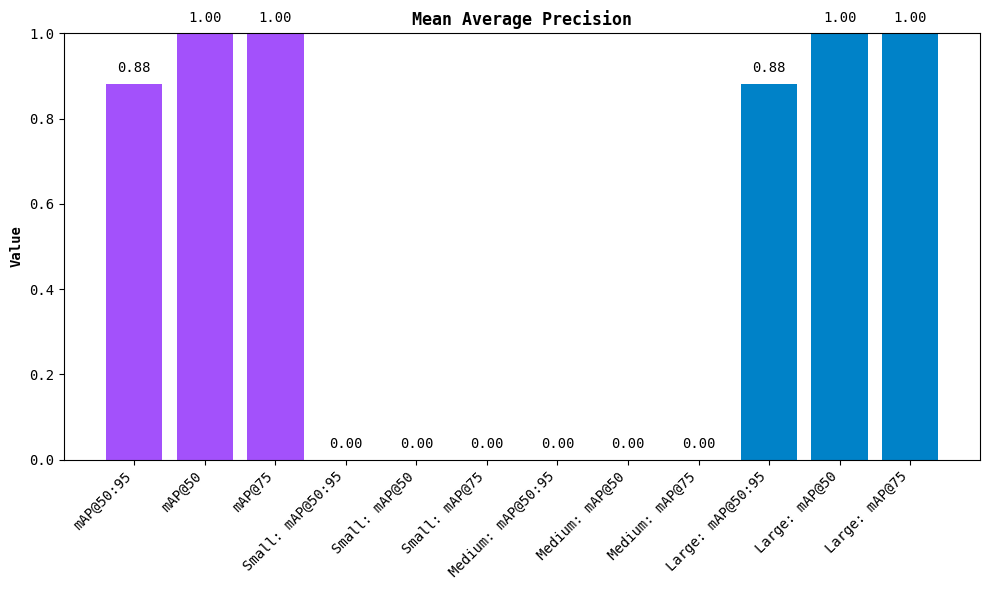

In [18]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [19]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

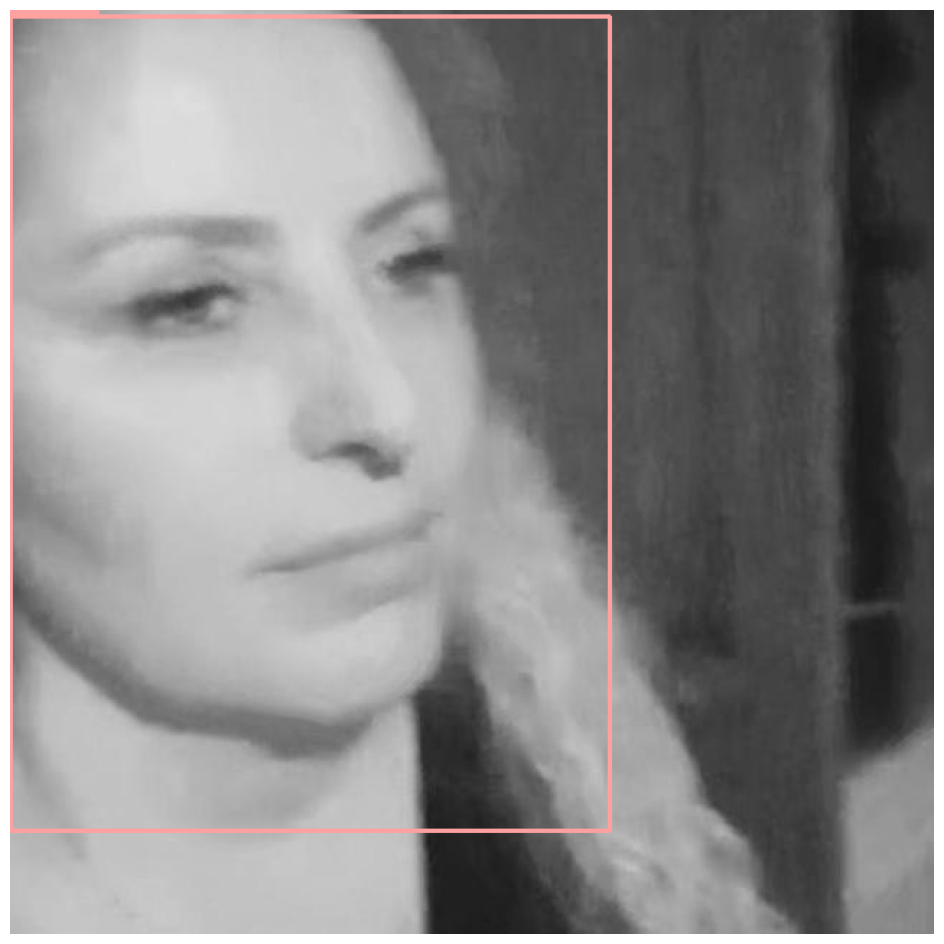

In [22]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)